In [1]:
import numpy as np
import os
import pandas as pd
import datetime
import xarray as xr
import tensorflow as tf
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
os.chdir("C://Users//Greg//code//space physics//experiment//data")

ss_file = "substorms_2000_2018.csv"
ind_file = "ae_index_2000_2018.hdf"

ind = pd.read_hdf(ind_file, key='data').astype(float)
ss = pd.read_csv(ss_file)
ss.index = pd.to_datetime(ss.Date_UTC)
ss = ss.drop(columns=['Date_UTC'])

start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2011, 1, 1)

ss = ss[(ss.index > start) * (ss.index < end)]
ind = ind[(ind.index > start) * (ind.index < end)]

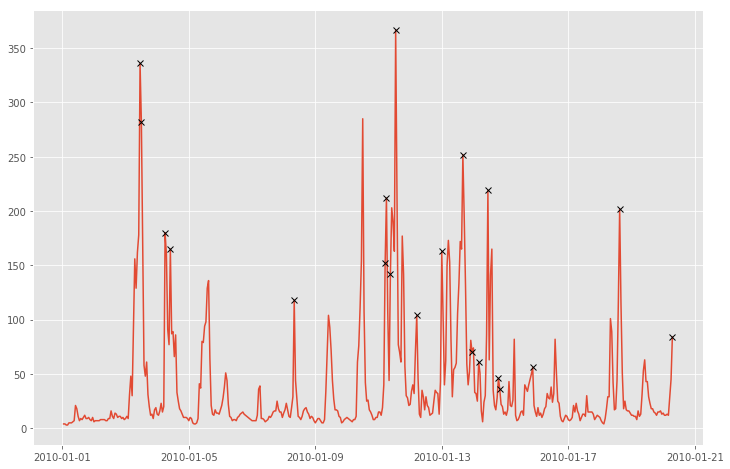

In [3]:
ss_indices = np.argmin(abs(ss.index[:,None] - ind.index[None,:]), axis=1)[:20]
plt.figure(figsize=(12,8))
plt.plot(ind.ae.iloc[:ss_indices[-1]+1])
plt.plot(ind.ae.iloc[ss_indices], 'kx')

In [4]:
def plot_mag(stations, start, stop):
    plt.figure(figsize=(20,12))
    times = mag_data.Date_UTC[start:stop]
    for station in stations:
        data = mag_data[station].data.copy()

        N = data[start:stop,-3]
        E = data[start:stop,-2]
        Z = data[start:stop,-1]

        N -= np.nanmean(N)
        E -= np.nanmean(E)
        Z -= np.nanmean(Z)

        plt.plot(times, N)
        plt.plot(times, E)
        plt.plot(times, Z)

In [5]:
mag_file = "mag_data_2010.nc"
mag_data = xr.open_dataset(mag_file)
stations_to_drop = [station for station in mag_data if np.any(np.all(np.isnan(mag_data[station]), axis=0))]
mag_data = mag_data.drop(stations_to_drop)

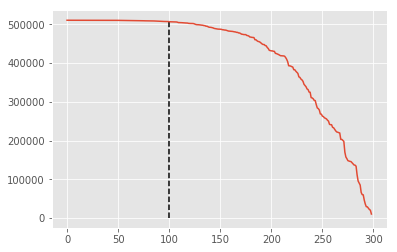

In [6]:
X = np.isfinite(mag_data.sel(dim_1='N').to_array()).sum(dim='Date_UTC')
sort_ind = np.argsort(X)[::-1]

n_stations = 100
best_stations = [station for i,station in enumerate(mag_data) if i in sort_ind[:n_stations]]

plt.plot(X[sort_ind.values])
plt.vlines(n_stations, 0, X.max(), 'k', 'dashed')

In [7]:
# create smaller dataset
data = mag_data[best_stations].sel(dim_1=['N','E','Z']).copy().to_array()
data = data.rename({'dim_1': 'component', 'Date_UTC': 'time', 'variable': 'station'})
data -= data.mean(dim='time')
data /= data.std(dim='time')
data = data.transpose('time', 'station', 'component')
data

<xarray.DataArray (time: 510844, station: 100, component: 3)>
array([[[-0.599517,  0.185659, -1.076688],
        [ 0.255578, -0.219179, -1.660861],
        ...,
        [-0.236464, -0.009648, -0.532814],
        [ 0.274092, -0.007016, -1.455041]],

       [[-0.599517,  0.177967, -1.076688],
        [ 0.255578, -0.219179, -1.692843],
        ...,
        [-0.236464, -0.009648, -0.532814],
        [ 0.274092, -0.007016, -1.455041]],

       ...,

       [[-0.451125,  0.101049, -0.835158],
        [-4.411307, -3.432895,  1.665275],
        ...,
        [ 0.283989,  0.14744 ,  0.89529 ],
        [-0.333489,  0.057354,  1.451036]],

       [[-0.457061,  0.101049, -0.832381],
        [-4.411169, -3.433245,  1.665275],
        ...,
        [ 0.283989,  0.14744 ,  0.89529 ],
        [-0.34159 , -0.014168,  1.451036]]])
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 ... 2010-12-31T23:59:00
  * component  (component) object 'N' 'E' 'Z'
  * station    (station) <U3 'A02' 'ABG' 'ABK'

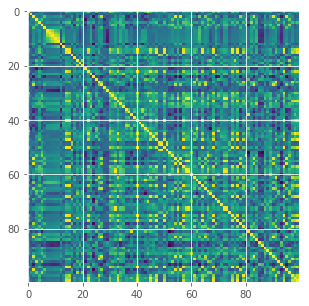

In [9]:
iterations = 50

X = tf.placeholder(tf.float32, shape=(None, data.shape[1], data.shape[2]))
XXT = X[:,None,:,:] * X[:,:,None,:]
cov_matrix = tf.reduce_sum(tf.where(tf.is_nan(XXT), tf.zeros_like(XXT), XXT), axis=0)

cov = np.zeros((data.shape[1], data.shape[1], data.shape[2]))

with tf.device("/gpu:0"):
    sess = tf.Session()
    for i in range(iterations):
        cov += sess.run(cov_matrix, {X:data.values[i::iterations,:,:]})
    cov /= data.shape[0]
        
plt.figure(figsize=(5,5))
plt.imshow(cov[:,:,0])

In [10]:
# Missing value imputation using linear gaussian model
# Bishop page 87
# rewrite in tensorflow to utilize GPU
missing_entries = np.unique(np.argwhere(np.isnan(data.values))[:,0])
for i,time in enumerate(missing_entries):
    if i % (missing_entries.shape[0] // 10) == 0:
        print("{} %".format(int( 100 * i / missing_entries.shape[0])))
    for comp in range(3):
        nans = np.isnan(data.values[time,:,comp])
        if nans.sum() == 0:
            continue
        sig_ab = cov[nans,:,comp][:,~nans]
        sig_bb = cov[~nans,:,comp][:,~nans]
        sig_bb_inv = np.linalg.inv(sig_bb)
        sig_aa = cov[nans,:,comp][:,nans]
        mu_agb = np.dot(sig_ab, sig_bb_inv).dot(data.values[time,:,comp][~nans].reshape((-1, 1)))
        sig_agb = sig_aa - np.dot(sig_ab, sig_bb_inv).dot(sig_ab.T)
        data[time,nans,comp] = np.random.multivariate_normal(mu_agb[:,0], sig_agb)

0 %
9 %
19 %
29 %
39 %
49 %
59 %
69 %
79 %
89 %
99 %


In [11]:
# double check the numbers here
interval = 90

batches = np.empty((data.shape[0]//interval, interval, data.shape[1]*data.shape[2]), dtype=np.float32)
targets = np.zeros(batches.shape[0], dtype=np.float32)

for i,t in enumerate(range(0, data.shape[0]-interval, interval)):
    if i % (batches.shape[0] // 10) == 0:
        print("{} %".format(int( 100 * i / batches.shape[0])))
    batches[i] = data[t:t+interval].stack(sxc=('station','component')).values
    targets[i] = np.any((ss.index < data.time.values[t+interval]) * (ss.index >= data.time.values[t]))    
    
print(batches.shape)
print(targets.shape)

0 %
9 %
19 %
29 %
39 %
49 %
59 %
69 %
79 %
89 %
99 %
(5676, 90, 300)
(5676,)


In [12]:
class MagCNN:
    """Ideas:
        - make modules like conv-act-bn or something
        - define how many of those to make
        - pass in a list or something with the number of filters in each layer
    """
    
    def __init__(self, input_shape, lr, cw):
        # clear old variables
        tf.reset_default_graph()
        
        self.X = tf.placeholder(tf.float32, [None, input_shape[0], input_shape[1]])
        self.y = tf.placeholder(tf.float32, [None,])
        self.is_training = tf.placeholder(tf.bool)
        
        self.make_layers()
        
        total_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=self.y, logits=self.scores[:,0])
        pos_weight = tf.reduce_sum(self.y) / tf.cast(tf.shape(self.y)[-1], tf.float32)
        class_weights = (cw / (pos_weight+1)) * tf.cast(tf.equal(self.y, tf.ones_like(self.y)), \
                                                        tf.float32) + tf.ones_like(self.y)

        self.loss = tf.reduce_mean(tf.multiply(total_loss, class_weights))

        # define our optimizer
        optimizer = tf.train.AdamOptimizer(lr) # select optimizer and set learning rate
        self.train_step = optimizer.minimize(self.loss)
        
    def make_layers(self):
        conv1act = tf.layers.conv1d(self.X, 32, kernel_size=10, strides=1, activation=tf.nn.relu)
        conv2act = tf.layers.conv1d(conv1act, 64, kernel_size=10, strides=1, activation=tf.nn.relu)
        maxpool1act = tf.layers.max_pooling1d(conv2act, pool_size=2, strides=2)
        conv3act = tf.layers.conv1d(maxpool1act, 64, kernel_size=6, strides=1, activation=tf.nn.relu)
        conv4act = tf.layers.conv1d(conv3act, 64, kernel_size=6, strides=1, activation=tf.nn.relu)
        maxpool2act = tf.layers.max_pooling1d(conv3act, pool_size=2, strides=2)
        flatten1 = tf.layers.flatten(maxpool2act)
        fc1 = tf.layers.dense(flatten1, units=256 , activation=tf.nn.relu)
        dpout1 = tf.layers.dropout(fc1, training=self.is_training)
        fc2 = tf.layers.dense(dpout1, units=256 , activation=tf.nn.relu)
        dpout2 = tf.layers.dropout(fc2, training=self.is_training)
        self.scores = tf.layers.dense(dpout2, units=1, activation=None)
        
    def train_model(self, sess, X_train, y_train, X_val, y_val, epochs, batch_size):
        
        # have tensorflow compute accuracy
        prediction = tf.nn.sigmoid(self.scores)
        correct_prediction = tf.equal(tf.round(prediction)[:,0], self.y)
    
        # shuffle indicies
        train_indicies = np.arange(X_train.shape[0])
        np.random.shuffle(train_indicies)
        
        # setting up variables we want to compute (and optimizing)
        # if we have a training function, add that to things we compute
        variables = [self.loss, correct_prediction, self.train_step]
        
        val_losses = []
        val_accs = []
        train_losses = []
        train_accs = []
        
        for e in range(epochs):
            correct = 0
            epoch_loss = 0
            epoch_losses = []
            # make sure we iterate over the dataset once
            for i in range(int(np.ceil(X_train.shape[0]/batch_size))):
                # generate indicies for the batch
                start_idx = (i*batch_size) % X_train.shape[0]
                idx = train_indicies[start_idx:start_idx+batch_size]
            
                # create a feed dictionary for this batch
                feed_dict = {self.X: X_train[idx],
                             self.y: y_train[idx],
                             self.is_training: True}
                
                # get batch size
                actual_batch_size = idx.shape[0]
                
                # have tensorflow compute loss and correct predictions
                # and (if given) perform a training step
                loss, corr, _ = sess.run(variables, feed_dict=feed_dict)
            
                # aggregate performance stats
                epoch_loss += actual_batch_size * loss
                epoch_losses.append(loss)
                correct += np.sum(corr)

            epoch_accuracy = correct / X_train.shape[0]
            epoch_loss /= X_train.shape[0]
            train_losses.append(epoch_loss)
            train_accs.append(epoch_accuracy)
            print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
                  .format(epoch_loss, epoch_accuracy, e+1))
            
            val_idx = np.random.choice(X_val.shape[0], 2*batch_size, replace=False)
            val_dict = {self.X: X_val[val_idx], self.y: y_val[val_idx], self.is_training: False}
            val_loss, val_corr = sess.run([self.loss, correct_prediction], val_dict)
            val_losses.append(val_loss)
            val_accs.append(val_corr.sum() / val_idx.shape[0])
        
        plt.figure(figsize=(12, 12))
        
        plt.subplot(211)
        plt.plot(train_losses, label='train loss')
        plt.plot(val_losses, label='val loss')
        plt.grid(True)
        plt.title('Loss')
        plt.xlabel('epoch number')
        plt.ylabel('loss')
        plt.legend()
        plt.subplot(212)
        plt.plot(train_accs, label='train acc')
        plt.plot(val_accs, label='val acc')
        plt.grid(True)
        plt.title('Accuracy')
        plt.xlabel('epoch number')
        plt.ylabel('Accuracy')
        plt.legend()
        
    def predict(self, sess, X):
        confidences = tf.nn.sigmoid(self.scores)
        predictions = tf.round(confidences)        
        feed_dict = {self.X: X, self.is_training: False}
        return sess.run(predictions, feed_dict=feed_dict)
        

Epoch 1, Overall loss = 1.04 and accuracy of 0.543
Epoch 2, Overall loss = 0.938 and accuracy of 0.654
Epoch 3, Overall loss = 0.87 and accuracy of 0.735
Epoch 4, Overall loss = 0.803 and accuracy of 0.783
Epoch 5, Overall loss = 0.752 and accuracy of 0.805
Epoch 6, Overall loss = 0.702 and accuracy of 0.832
Epoch 7, Overall loss = 0.655 and accuracy of 0.845
Epoch 8, Overall loss = 0.626 and accuracy of 0.851
Epoch 9, Overall loss = 0.589 and accuracy of 0.859
Epoch 10, Overall loss = 0.567 and accuracy of 0.867
Epoch 11, Overall loss = 0.518 and accuracy of 0.878
Epoch 12, Overall loss = 0.509 and accuracy of 0.877
Epoch 13, Overall loss = 0.497 and accuracy of 0.88
Epoch 14, Overall loss = 0.472 and accuracy of 0.884
Epoch 15, Overall loss = 0.447 and accuracy of 0.885
Epoch 16, Overall loss = 0.426 and accuracy of 0.886
Epoch 17, Overall loss = 0.419 and accuracy of 0.891
Epoch 18, Overall loss = 0.403 and accuracy of 0.892
Epoch 19, Overall loss = 0.39 and accuracy of 0.901
Epoch 

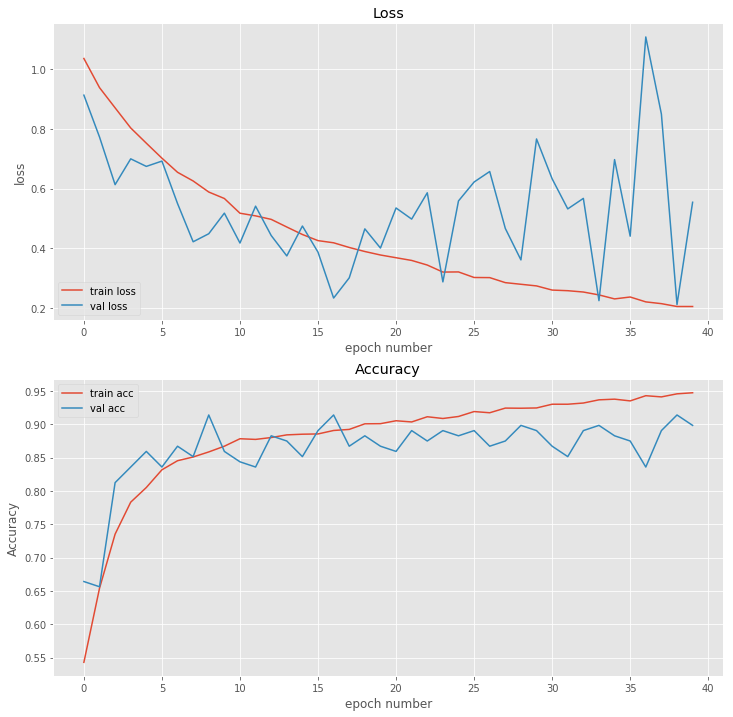

In [13]:
tv_split = 5000

idx = np.arange(batches.shape[0])
np.random.shuffle(idx)
train_idx = idx[:5000]
val_idx = idx[5000:]

X_train = batches[train_idx]
y_train = targets[train_idx]
X_val = batches[val_idx]
y_val = targets[val_idx]

model = MagCNN(batches.shape[1:], 2e-5, 4)

sess = tf.Session()
with tf.device("/gpu:0"):
    sess.run(tf.global_variables_initializer())
    model.train_model(sess, X_train, y_train, X_val, y_val, 40, 64)

Normalized confusion matrix
[[0.90953947 0.09046053]
 [0.29411765 0.70588235]]


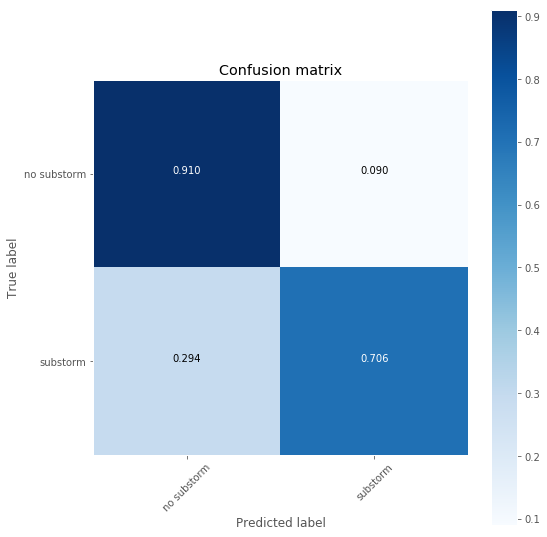

In [14]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

with tf.device("/gpu:0"):
    p = model.predict(sess, X_val)

plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_matrix(y_val, p), ['no substorm', 'substorm'], normalize=True)
plt.grid(False)